In [1]:
from pathlib import Path

# define path
folder = Path('../bookscraper/output')

# list .txt files
files = list(folder.glob('*.txt'))

# cast as strings
files = [str(file) for file in files]
files

['..\\bookscraper\\output\\emma1.txt',
 '..\\bookscraper\\output\\emma7.txt',
 '..\\bookscraper\\output\\gevoelenverstanddutch1.txt',
 '..\\bookscraper\\output\\ladysusan12.txt',
 '..\\bookscraper\\output\\ladysusan22.txt',
 '..\\bookscraper\\output\\loveandfreindshipsic10.txt',
 '..\\bookscraper\\output\\loveandfreindshipsic23.txt',
 '..\\bookscraper\\output\\mansfieldpark14.txt',
 '..\\bookscraper\\output\\mansfieldpark5.txt',
 '..\\bookscraper\\output\\northangerabbey16.txt',
 '..\\bookscraper\\output\\northangerabbey4.txt',
 '..\\bookscraper\\output\\oldfriendsandnewfanciesanimaginarysequeltothenovelsofjaneausten24.txt',
 '..\\bookscraper\\output\\persuasion17.txt',
 '..\\bookscraper\\output\\persuasion3.txt',
 '..\\bookscraper\\output\\persuasionfrench0.txt',
 '..\\bookscraper\\output\\prideandprejudice0.txt',
 '..\\bookscraper\\output\\prideandprejudice11.txt',
 '..\\bookscraper\\output\\prideandprejudice13.txt',
 '..\\bookscraper\\output\\prideandprejudice15.txt',
 '..\\bookscra

## Load the contents of each book into Python

In [2]:
import re
import pandas as pd

# check which files are in English
austen_files = pd.read_csv(Path('../bookscraper/booksdata.csv'))
austen_files = austen_files[austen_files['language'].str.contains("English")]
english_files = austen_files['file_name'].to_list()

# create containers for texts and titles
texts = []
titles = []

# extract content and store in containers

for file_name in set(english_files):
    # open and read file
    file = Path("..\\bookscraper\\output\\"+file_name)
    f = open(file,encoding='utf-8-sig')
    txt = f.read()    
    if txt:
        txt = re.sub(r'[^A-Za-z0-9\s]','',txt)
        txt = txt.replace('\n','')
        # define patterns to remove header and footer from PG
        pattern = r'(START OF THE PROJECT GUTENBERG EBOOK)(.*)(END OF THE PROJECT GUTENBERG EBOOK)'
        
        # clean text
        match = re.search(pattern, txt)

        if match:
            txt = match.group(2) 

        texts.append(txt)
        title = file_name.replace('.txt','')
        titles.append(title)

 
# print length of each text
[len(t) for t in texts]

[828715,
 406693,
 687477,
 2956,
 186236,
 634337,
 411058,
 121415,
 653378,
 587296,
 651647,
 177710,
 441438,
 4117529,
 4074,
 838137,
 144355]

## Find and store index of Pride and Prejudice 0

In [3]:
# find the index of "PrideandPrejudice0" and save it in ppi
for i in range(len(titles)):
    if "PrideandPrejudice0" in titles[i]:
        ppi = i

print(ppi)        

2


## Tokenize corpus

In [4]:
# convert to lowercase
txts_lower_case = [txt.lower() for txt in texts]

# tokenize texts
txts_split = [txt.split() for txt in txts_lower_case]

# remove stopwords
from nltk.corpus import stopwords

stp_words = set(stopwords.words('english'))
txts = [[word for word in txt if word not in stp_words] for txt in txts_split]

# print first 20 tokens
print(txts[ppi][:21])


['pride', 'prejudice', 'illustration', 'george', 'allen', 'publisher', '156', 'charing', 'cross', 'road', 'london', 'ruskin', 'house', 'illustration', 'reading', 'janes', 'letters', 'chap', '34', 'pride', 'prejudice']


## Stem the tokenized corpus

In [5]:
from nltk.stem import PorterStemmer

# initialize the class and apply to each word of each text
ps = PorterStemmer()
txts_stem = [[ps.stem(word) for word in txt] for txt in txts]

# print first 20 stemmed tokens of Pride and Prejudice 0
print(txts_stem[ppi][:21])


['pride', 'prejudic', 'illustr', 'georg', 'allen', 'publish', '156', 'chare', 'cross', 'road', 'london', 'ruskin', 'hous', 'illustr', 'read', 'jane', 'letter', 'chap', '34', 'pride', 'prejudic']


## Build BoW model

In [6]:
import gensim

# create a dictionary from the stemmed tokens
dict = gensim.corpora.Dictionary(txts_stem)

# create BoW model for each text
bows = [dict.doc2bow(text) for text in txts_stem]

# print the first 5 elements of the BoW Pride and Prejudice 0 model
print(bows[ppi][:5])

[(18, 2), (19, 6), (20, 49), (25, 1), (27, 8)]


In [7]:
# creade BoW dataframe for Pride and Prejudice
df_bow_pp = pd.DataFrame(bows[ppi])

# add column names
df_bow_pp = df_bow_pp.rename(columns={0:'index',
                                      1:'occurrences'})

# add token column
df_bow_pp['token'] = [dict[id] for id in df_bow_pp['index']]

# sort by occurrence and show first 10 more frequent tokens
df_bow_pp.sort_values(by='occurrences', ascending=False)[:10]

,index,occurrences,token
2334,9030,911,mr
799,3070,459,could
1085,4033,404,elizabeth
4116,16031,402,would
3019,11718,355,said
4327,17880,346,darci
4262,17218,289,bennet
2335,9077,283,much
2346,9142,275,must
2288,8810,254,miss


### tf-idf model

In [8]:
from gensim.models import TfidfModel

# generate the model

model = TfidfModel(bows)

# print the model for Pride and Prejudice
model[bows[ppi][:10]]

[(18, 0.2231410967346733),
 (19, 0.1724340989936671),
 (20, 0.6570252613021719),
 (25, 0.02873901649894452),
 (27, 0.3730836446882522),
 (29, 0.5116139825585453),
 (31, 0.19011289203888157),
 (48, 0.05684599806206058),
 (51, 0.17053799418618174),
 (52, 0.13626645821472239)]

In [9]:
# convert model into DataFrame

df_tfidf_pp = pd.DataFrame(model[bows[ppi]])

# name columns
df_tfidf_pp = df_tfidf_pp.rename(columns={0:'id',
                                           1:'score'})

# add tokens

df_tfidf_pp['token'] = [dict[id] for id in df_tfidf_pp['id']]

# sort and display first 10 values
df_tfidf_pp.sort_values(by='score', ascending=False)[:10]

,id,score,token
4302,17880,0.437475,darci
4237,17218,0.365405,bennet
4245,17278,0.317359,bingley
12572,30716,0.270295,wickham
8963,27107,0.238906,lydia
1082,4033,0.200516,elizabeth
6267,24411,0.197377,collin
2324,9030,0.162480,mr
4803,22947,0.145341,1894
4370,18675,0.126143,gardin


### Compute distance between texts

In [10]:
# compute similarity matrix

sims = gensim.similarities.MatrixSimilarity(bows)

# convert into DataFrame

sim_df = pd.DataFrame(list(sims))

# add labels of the books
sim_df.columns = titles
sim_df.index = titles

# print matrix

sim_df.head()


,Emma1,TheLettersofJaneAusten8,PrideandPrejudice0,Emma7,TheWatsonsByJaneAustenConcludedbyLOulton21,SenseandSensibility2,NorthangerAbbey4,LadySusan12,PrideandPrejudice6,OldFriendsandNewFanciesAnImaginarySequeltotheNovelsofJaneAusten24,SenseandSensibility19,LoveandFreindshipsic10,Persuasion3,TheCompleteProjectGutenbergWorksofJaneAusten18,SenseandSensibility9,MansfieldPark5,PrideandPrejudiceaplayfoundedonJaneAustensnovel20
Emma1,1.000001,0.780336,0.835448,0.012137,0.779244,0.793158,0.783473,0.693095,0.840913,0.804997,0.794122,0.680979,0.788490,0.926976,0.031162,0.803239,0.700511
TheLettersofJaneAusten8,0.780336,1.000000,0.780976,0.023385,0.693522,0.738540,0.748404,0.699407,0.775488,0.742972,0.741267,0.717909,0.736748,0.838947,0.025284,0.772750,0.671882
PrideandPrejudice0,0.835448,0.780976,1.000000,0.011635,0.738438,0.808050,0.797822,0.738502,0.994754,0.872431,0.808913,0.728774,0.798141,0.922921,0.029156,0.802615,0.851785
Emma7,0.012137,0.023385,0.011635,1.000000,0.013597,0.010794,0.014541,0.012787,0.011163,0.010662,0.011364,0.016374,0.011917,0.013525,0.083859,0.013174,0.010662
TheWatsonsByJaneAustenConcludedbyLOulton21,0.779244,0.693522,0.738438,0.013597,1.000000,0.697950,0.691161,0.608517,0.734217,0.714972,0.698814,0.640338,0.697437,0.792117,0.017694,0.700616,0.595781


### Most similar book to Pride and Prejudice 0

Text(0.5, 1.0, 'Similarity to Pride and Prejudice 0')

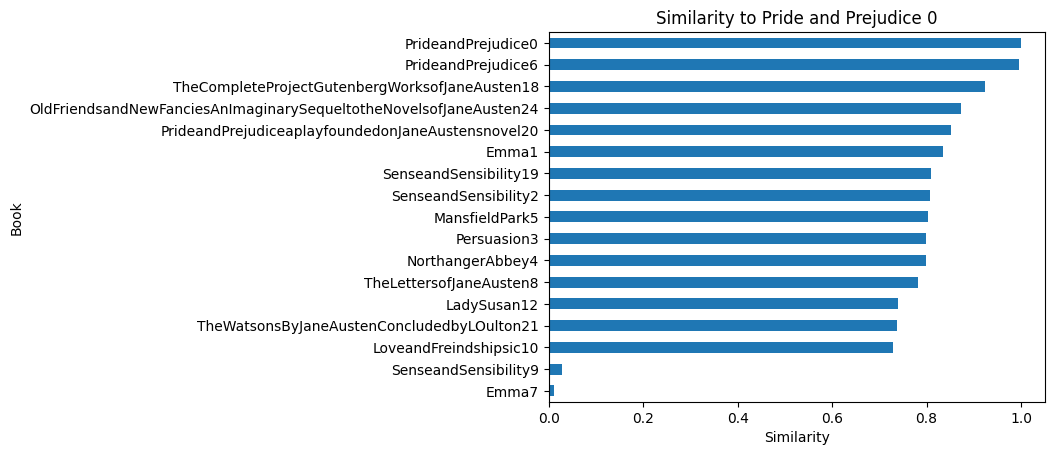

In [11]:
%matplotlib inline

import matplotlib.pyplot as plt

# select column
v = sim_df['PrideandPrejudice0']

# sort by score
v_sorted = v.sort_values()

# plot
barplot = v_sorted.plot.barh()

# add labels
plt.xlabel('Similarity')
plt.ylabel('Book')
plt.title('Similarity to Pride and Prejudice 0')


### Books with similar content

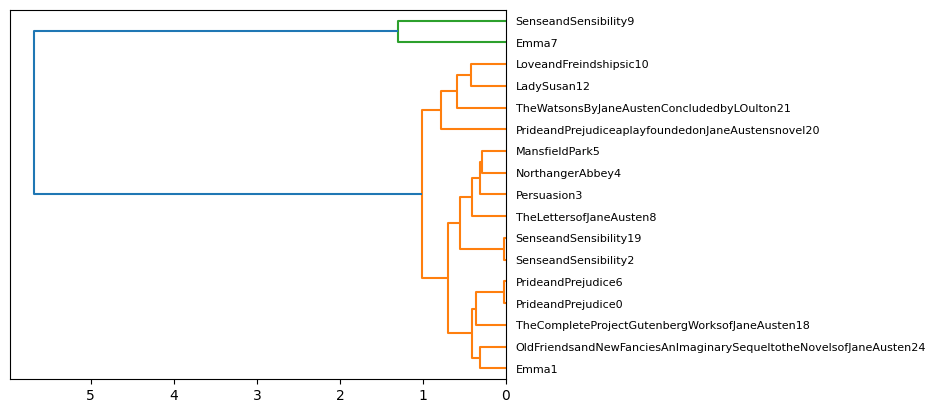

In [13]:
from scipy.cluster import hierarchy

# compute clusters from similarity matriy using the Ward variance minimization algorithm
Z = hierarchy.linkage(sim_df, method='ward')

# vis
a = hierarchy.dendrogram(Z,
                         leaf_font_size = 8,
                         labels = sim_df.index,
                         orientation='left')